In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM, Masking, Input, GRU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
from qkeras import *
import qkeras
from tensorflow.keras.models import load_model
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights

In [2]:
file_path = "./Jan06_FlavFix_smear_1_std_xtd_zst.h5"
f5 = h5py.File(file_path, 'r')

In [3]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )
w_train = np.array( f5['w_train'] )

(array([[400610.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300906.],
        [601755.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  99761.],
        [400667.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300849.]]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <a list of 3 BarContainer objects>)

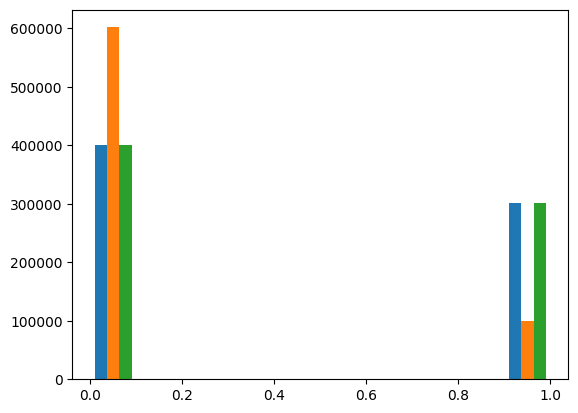

In [5]:
plt.hist(y_train[:])

In [4]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(x_train, y_train, w_train,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)

### Shuffle training data

In [5]:
x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [6]:
print("x-shape: ", x_train.shape)
print("y-shape: ", y_train.shape)
print("w-shape: ", w_train.shape)

x-shape:  (701516, 15, 6)
y-shape:  (701516, 3)
w-shape:  (701516,)


### GRU

In [13]:
def grumodel(max_len, n_var, rec_units, ndense=[50, 10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform'):
    
    hidden = x_in = Input(shape=(max_len, n_var,))
    hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'gru')(hidden)
    
    hidden = Dense(50, kernel_initializer=dense_kernel_init, name='dense_0' )(hidden)
    hidden = Activation('relu', name = 'relu_0')(hidden)
    
    hidden = Dense(10, kernel_initializer=dense_kernel_init, name='dense_1' )(hidden)
    hidden = Activation('relu', name = 'relu_1')(hidden)

    hidden = Dense(3, kernel_initializer=dense_kernel_init, name = 'dense_2')(hidden)
    hidden = Activation('softmax', name = 'output_softmax')(hidden)
    
    model = Model(inputs=x_in, outputs=hidden)
    
    return model

### LSTM

In [8]:
def lstmmodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False):
    
    hidden = x_in = Input(shape=(max_len, n_var,))
    hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'lstm1')(hidden)
    hidden = Dense(50, kernel_initializer=dense_kernel_init, name='dense_0' )(hidden)
    hidden = Activation('relu', name = 'relu_0')(hidden)
    hidden = Dense(10, kernel_initializer=dense_kernel_init, name='dense_1' )(hidden)
    hidden = Activation('relu', name = 'relu_1')(hidden)
    hidden = Dense(3, kernel_initializer=dense_kernel_init, name='dense_2' )(hidden)
    hidden = Activation('softmax', name='output_softmax')(hidden)
    model = Model(inputs=x_in, outputs=hidden)
    
    return model

## Floating Point Model Training

In [16]:
l1_reg = 0
l2_reg = 0

## GRU Model
model = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
#model = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
model_output = 'gru_test3/gru_weights.h5'

train = True
if train:
    history = model.fit(x_train, y_train,
            batch_size=2**10,
            epochs=150,
            validation_data=(x_val, y_val), 
            shuffle = True,
            sample_weight= w_train,
            callbacks = [
                EarlyStopping(verbose=True, patience=20, monitor='val_accuracy'),
                ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                ],
            verbose=True
            )
y_keras = model.predict(x_test, batch_size=2**10)
auc_score = roc_auc_score(y_test, y_keras)
print("AUC score:", auc_score)

Epoch 1/150
613/617 [============================>.] - ETA: 0s - loss: 0.7872 - accuracy: 0.6725
Epoch 1: val_accuracy improved from -inf to 0.70236, saving model to gru_test3\gru_weights.h5
617/617 [==============================] - 6s 7ms/step - loss: 0.7869 - accuracy: 0.6727 - val_loss: 0.7392 - val_accuracy: 0.7024
Epoch 2/150
616/617 [============================>.] - ETA: 0s - loss: 0.7305 - accuracy: 0.7050
Epoch 2: val_accuracy improved from 0.70236 to 0.71030, saving model to gru_test3\gru_weights.h5
617/617 [==============================] - 4s 6ms/step - loss: 0.7305 - accuracy: 0.7050 - val_loss: 0.7176 - val_accuracy: 0.7103
Epoch 3/150
615/617 [============================>.] - ETA: 0s - loss: 0.7149 - accuracy: 0.7123
Epoch 3: val_accuracy improved from 0.71030 to 0.71569, saving model to gru_test3\gru_weights.h5
617/617 [==============================] - 4s 6ms/step - loss: 0.7149 - accuracy: 0.7123 - val_loss: 0.7085 - val_accuracy: 0.7157
Epoch 4/150
610/617 [=======

617/617 [==============================] - 4s 6ms/step - loss: 0.6441 - accuracy: 0.7442 - val_loss: 0.6785 - val_accuracy: 0.7324
Epoch 28/150
611/617 [============================>.] - ETA: 0s - loss: 0.6423 - accuracy: 0.7454
Epoch 28: val_accuracy did not improve from 0.73311
617/617 [==============================] - 4s 6ms/step - loss: 0.6423 - accuracy: 0.7454 - val_loss: 0.6792 - val_accuracy: 0.7313
Epoch 29/150
611/617 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.7456
Epoch 29: val_accuracy did not improve from 0.73311
617/617 [==============================] - 3s 5ms/step - loss: 0.6407 - accuracy: 0.7456 - val_loss: 0.6782 - val_accuracy: 0.7300
Epoch 30/150
607/617 [============================>.] - ETA: 0s - loss: 0.6391 - accuracy: 0.7463
Epoch 30: val_accuracy did not improve from 0.73311
617/617 [==============================] - 3s 5ms/step - loss: 0.6391 - accuracy: 0.7464 - val_loss: 0.6769 - val_accuracy: 0.7319
Epoch 31/150
617/617 [====

## GRU weight

In [43]:
model = load_model("gru_test3/gru_weights.h5", custom_objects={'QGRU': QGRU, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})

for layer in model.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

input_1 []
gru [array([[-0.12469812, -0.28928995,  0.24783108, ...,  0.09020978,
         1.3361043 ,  0.2131291 ],
       [ 0.1327692 , -0.08152957,  0.25204852, ...,  0.08305766,
        -0.40952712, -0.08306952],
       [-0.03643114,  0.05480863, -0.37831095, ...,  0.08108549,
        -0.20789394,  0.2881709 ],
       [-0.3405804 , -0.132991  , -0.21851636, ..., -0.02375418,
         0.45972824,  0.17867932],
       [-0.5600249 ,  0.20899312, -0.61330974, ...,  0.16689596,
        -0.23248236, -0.6929572 ],
       [-0.2772438 , -0.26483715,  0.39346495, ...,  0.03653004,
        -0.3099163 ,  0.32959458]], dtype=float32), array([[-0.00120384,  0.02518557,  0.11613223, ...,  0.00860514,
        -0.17399853, -0.09032135],
       [ 0.1389099 , -0.01724965,  0.21604231, ...,  0.02770575,
        -0.20152883,  0.09281268],
       [ 0.22167127,  0.25377536, -0.02039688, ..., -0.06135429,
        -0.1431508 ,  0.08396748],
       ...,
       [-0.00848735, -0.08626914, -0.09164452, ...,  0.

## LSTM weight

In [21]:
model = load_model("lstm_test2/lstm_weights.h5")

for layer in model.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

input_1 []
lstm1 [array([[-0.58963495, -0.65306294,  0.50985825, ...,  1.0137032 ,
         0.02196546,  0.15770978],
       [-0.15424801,  0.57628304, -0.36964563, ..., -0.09466681,
         0.41260427, -0.08563282],
       [ 0.18494439, -0.03675471, -0.79524565, ...,  0.47767442,
        -0.09714114,  0.3135381 ],
       [-0.14735329,  0.6082327 , -0.61543125, ...,  0.26261836,
         0.08817887, -0.37429032],
       [ 0.34194303, -0.09358562,  0.01487087, ..., -0.5444205 ,
         0.01626718,  0.95701003],
       [-0.33648208, -0.5004817 , -0.34336048, ...,  0.1277528 ,
        -0.03531963,  0.3862824 ]], dtype=float32), array([[ 0.17079291,  0.15018411,  0.07714663, ..., -0.11801086,
        -0.07126733, -0.20896389],
       [ 0.00498595,  0.14601009, -0.00364938, ..., -0.19730644,
        -0.21843092, -0.11314441],
       [ 0.04462222,  0.07113124,  0.03417065, ...,  0.01916615,
        -0.07676554,  0.03190433],
       ...,
       [-0.17137632, -0.00948324,  0.07338994, ...,  

## Quantization Aware Training

## QGRU

In [14]:
from qkeras.utils import model_quantize

l1_reg = 0
l2_reg = 0

## GRU Model
model = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
#model = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)
# new_GRU_0int = []
# new_GRU_1int = []
# new_GRU_4int = []
# GRU_1int = []
for int_bits in [0]:
    for i in [1]:
        total_bits = i + int_bits + 1

        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
    
# for layer in qmodel.layers:
#         if hasattr(layer, "recurrent_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
#                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
#         elif hasattr(layer, "kernel_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
#         elif hasattr(layer, "quantized_relu"):
#             print(layer.name, "quantized_relu:", str(layer.quantizer))
#         else:
#             print(layer.name)
                
        qmodel.summary()
    
        qmodel.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
        model_output = f'{int_bits}int_qgru_test3/{i}frac_qgru_weights.h5'
    
        train = True
        if train:
            history = qmodel.fit(x_train, y_train,
                    batch_size=2**14,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    shuffle = True,
                    sample_weight= w_train,
                    callbacks = [
                        EarlyStopping(verbose=True, patience=15, monitor='val_accuracy'),
                        ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                        ],
                    verbose=True
                    )
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
#         if int_bits == 1:
#             new_GRU_1int.append(auc_score)
#         else:
#             new_GRU_4int.append(auc_score)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)            (None, 10)                510       
                                                                 
 relu_1 (QActivation)        (None, 10)                0         
                                                                 
 dense_2 (QDense)            (None, 3)                 33    

39/39 [==============================] - 6s 150ms/step - loss: 0.7814 - accuracy: 0.6869 - val_loss: 0.7784 - val_accuracy: 0.6930
Epoch 23/100
39/39 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.6880
Epoch 23: val_accuracy improved from 0.69298 to 0.69325, saving model to 0int_qgru_test3\1frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7797 - accuracy: 0.6880 - val_loss: 0.7727 - val_accuracy: 0.6933
Epoch 24/100
39/39 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.6834
Epoch 24: val_accuracy did not improve from 0.69325
39/39 [==============================] - 6s 149ms/step - loss: 0.7866 - accuracy: 0.6834 - val_loss: 0.7843 - val_accuracy: 0.6906
Epoch 25/100
39/39 [==============================] - ETA: 0s - loss: 0.7772 - accuracy: 0.6899
Epoch 25: val_accuracy did not improve from 0.69325
39/39 [==============================] - 6s 150ms/step - loss: 0.7772 - accuracy: 0.6899 - val_loss: 0.7

Epoch 50/100
39/39 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.7025
Epoch 50: val_accuracy did not improve from 0.70537
39/39 [==============================] - 6s 150ms/step - loss: 0.7537 - accuracy: 0.7025 - val_loss: 0.7492 - val_accuracy: 0.7044
Epoch 51/100
39/39 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.7019
Epoch 51: val_accuracy did not improve from 0.70537
39/39 [==============================] - 6s 151ms/step - loss: 0.7566 - accuracy: 0.7019 - val_loss: 0.7551 - val_accuracy: 0.7024
Epoch 52/100
39/39 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.7025
Epoch 52: val_accuracy improved from 0.70537 to 0.70595, saving model to 0int_qgru_test3\1frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7541 - accuracy: 0.7025 - val_loss: 0.7456 - val_accuracy: 0.7060
Epoch 53/100
39/39 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.7023
Epoch 53

39/39 [==============================] - 6s 153ms/step - loss: 0.7518 - accuracy: 0.7054 - val_loss: 0.7445 - val_accuracy: 0.7081
Epoch 79/100
39/39 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.7052
Epoch 79: val_accuracy did not improve from 0.70966
39/39 [==============================] - 6s 150ms/step - loss: 0.7497 - accuracy: 0.7052 - val_loss: 0.7418 - val_accuracy: 0.7054
Epoch 80/100
39/39 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.7056
Epoch 80: val_accuracy did not improve from 0.70966
39/39 [==============================] - 6s 151ms/step - loss: 0.7484 - accuracy: 0.7056 - val_loss: 0.7459 - val_accuracy: 0.7056
Epoch 81/100
39/39 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7047
Epoch 81: val_accuracy did not improve from 0.70966
39/39 [==============================] - 6s 150ms/step - loss: 0.7518 - accuracy: 0.7047 - val_loss: 0.7482 - val_accuracy: 0.7044
Epoch 82/100
39/39 [============

In [15]:
new_GRU_0int = [0.5,
 0.7781852581610716,
 0.8052689666277991,
 0.8109481442592763,
 0.8096145296807965,
 0.8098533637530895,
 0.8098044762631676,
 0.8102405117880721,
 0.8088770528380856,
 0.8080757363803815,
 0.8104842146160554]

In [16]:
new_GRU_1int = [0.7232899902359936,
 0.8022549465153025,
 0.8127439006917948,
 0.8127788192719922,
 0.8149285481277914,
 0.8157051415690736,
 0.8142874540627472,
 0.8158298377306572,
 0.815492247747267,
 0.8149574890543141,               
 0.8154144400719504   
]

In [17]:
new_GRU_2int = [0.7978861613889471,
               0.815849389770993,
               0.8148355533804551,
               0.8158200221813354,
               0.816062740619869,
               0.8163306571855808,
               0.8159478210247729,
               0.8155296197340113,
               0.8145494177108477,
               0.8153537219752801]

In [18]:
new_GRU_4int = [0.8052859216963503,
               0.8154939012868634,
               0.8152980929728308,
               0.8168268261447293,
               0.8162396578910052,
               0.8153282912603489,
               0.8153629789775562,
               0.8154127637391237,
               0.8157062406265004,
               0.8157053507091959]

In [42]:
GRU_0int = [0.8057035080923204,0.8063085605847884,0.8087010364068309,0.808390807100588,0.8072937029408244,0.807904290865066,0.807594808925304, 0.8104042663672711, 0.8102821532555665]

In [36]:
# GRU_1int = [0.8145077019922606,0.812157712087822,0.8130202223907693,0.8139819536248997,0.8127072783557058,0.8134819222740655,0.8129857371136753]

In [43]:
GRU_2int = [0.8151518448562141, 0.8148535927175784, 0.8137848318442513, 0.8133497089089783, 0.8151228400404543, 0.8154264982587472, 0.8154788509534191, 0.8161041133333639, 0.8153584440639041]

In [44]:
GRU_4int = [0.8166665463673946, 0.8166382603323238, 0.8151867870435542, 0.8143344103276192, 0.8155274196768194, 0.8149202709172529, 0.8158216152291479, 0.8155521344977489, 0.8146970399632473]

(0.7, 0.82)

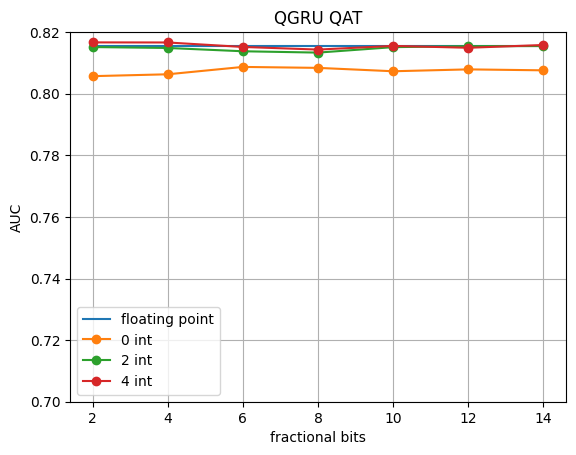

In [5]:
GRU_float = [0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825]
plt.plot([2,4,6,8,10,12, 14], GRU_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12, 14], GRU_0int, "-o", label = '0 int')
# plt.plot([2,4,6,8,10,12, 14], GRU_1int, "-o", label = '1 int')
plt.plot([2,4,6,8,10,12, 14], GRU_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12, 14], GRU_4int, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU QAT")
plt.grid()
plt.ylim([0.7, 0.82]) 

## QGRU weight

In [25]:
qgru = load_model('0int_qgru_test3/2frac_qgru_weights.h5', custom_objects={'QGRU': QGRU, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qgru, f"ptq2int2fra_weight")

... quantizing model


{'gru': {'weights': [array([[-0.25, -0.75, -0.25, ..., -0.25,  0.  , -0.75],
          [ 0.  ,  0.75, -0.5 , ...,  0.  , -0.75,  0.25],
          [-0.25, -0.75,  0.25, ...,  0.  ,  0.25,  0.75],
          [-0.5 ,  0.75,  0.5 , ...,  0.  , -0.75, -0.25],
          [ 0.25, -0.75, -0.5 , ...,  0.75, -0.25,  0.  ],
          [-0.75,  0.25,  0.25, ..., -0.5 ,  0.75, -0.5 ]], dtype=float32),
   array([[ 0.   ,  0.25 ,  0.   , ...,  0.125,  0.   ,  0.125],
          [-0.25 ,  0.125, -0.125, ...,  0.125,  0.25 , -0.125],
          [ 0.   ,  0.   , -0.125, ...,  0.   ,  0.125, -0.25 ],
          ...,
          [ 0.25 , -0.125, -0.125, ...,  0.25 ,  0.   , -0.125],
          [ 0.25 , -0.125,  0.   , ..., -0.125,  0.125,  0.   ],
          [ 0.   ,  0.25 ,  0.25 , ...,  0.   ,  0.25 ,  0.   ]],
         dtype=float32),
   array([[ 0.  , -0.5 ,  0.  ,  0.  ,  0.  , -0.25,  0.  ,  0.  , -0.75,
           -0.25, -0.25, -0.5 , -0.5 ,  0.  ,  0.  , -0.75,  0.  , -0.75,
           -0.25, -0.5 ,  0.  , 

## QLSTM

In [13]:


l1_reg = 0
l2_reg = 0

## GRU Model
#model = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
model = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)
# new_LSTM_0int = []
# new_LSTM_1int = []
# new_LSTM_2int = []
# new_LSTM_4int = []
for int_bits in [0]:
    for i in [1]:
        total_bits = i + int_bits + 1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
    
# for layer in qmodel.layers:
#         if hasattr(layer, "recurrent_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
#                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
#         elif hasattr(layer, "kernel_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
#         elif hasattr(layer, "quantized_relu"):
#             print(layer.name, "quantized_relu:", str(layer.quantizer))
#         else:
#             print(layer.name)
                
        qmodel.summary()
    
        qmodel.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
        model_output = f'{int_bits}int_qlstm_test3_notweight/{i}frac_qlstm_weights.h5'
    
        train = True
        if train:
            history = qmodel.fit(x_train, y_train,
                    batch_size=2**14,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    shuffle = True,
                    sample_weight= w_train,
                    callbacks = [
                        EarlyStopping(verbose=True, patience=15, monitor='val_accuracy'),
                        ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                        ],
                    verbose=True
                    )
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
#         if int_bits == 1:
#             new_LSTM_1int.append(auc_score)
# #         elif int_bits == 0:
# #             new_LSTM_0int.append(auc_score)
# #         else:
# #             new_LSTM_4int.append(auc_score)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 lstm1 (QLSTM)               (None, 120)               60960     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)            (None, 10)                510       
                                                                 
 relu_1 (QActivation)        (None, 10)                0         
                                                                 
 dense_2 (QDense)            (None, 3)                 33  

In [19]:
new_LSTM_0int = [0.5,
 0.759375387751892,
 0.7989484355227177,
 0.8030819593925612,
 0.8033667163742876,
 0.8027039533598156,
 0.8021881530344409,
 0.8025180589575464,
 0.8034173200659785,
 0.8019820586472483,
 0.8033968296080705]

In [20]:
new_LSTM_1int = [0.7461276916152187,
 0.8004789138627902,
 0.8060313884130137,
 0.8066705966334711,
 0.8047598230808163,
 0.8063869565793077,
 0.8037114278686879,
 0.8057039744583717,
 0.8058117425449095,
 0.8050323066709777,
 0.8061466588554641]

In [21]:
new_LSTM_2int = [0.795510871376552,
 0.8085795267629757,
 0.8079066913892133,
 0.8080574959094543,
 0.8072038114910124,
 0.8068566714570489,
 0.8066996444167445,
 0.8073183018132967,
 0.8078155800426238,
 0.8070635898235619]

In [22]:
new_LSTM_4int = [0.8053497730620925,
 0.808071073300117,
 0.8066011183389149,
 0.8084180335188978,
 0.8082054539904887,
 0.8074122711848334,
 0.8085630838564253,
 0.8083730126609362,
 0.8073775819301302,
 0.8071676088396639]

In [48]:
AUC_0int = [0.8019966937943156, 0.8056019505295176, 0.8043834232982888, 0.8035633347009626, 0.8042207873580036, 0.8038967592937954, 0.8061902536804495, 0.8047251266528449, 0.8064546998059575]

In [49]:
AUC_2int = [0.8092423670870935, 0.805096025589327, 0.8058041858617452, 0.8051723112723406, 0.8069855747085065, 0.8056181357932739, 0.8075191545354666, 0.8066674305760979, 0.8096005409705623]

In [50]:
AUC_4int = [0.8075657360375654, 0.8087467928467528, 0.8099972878505698, 0.8080579592351906, 0.8068300154461987, 0.8073075475855531, 0.8068326358740538, 0.8109530010286977, 0.8096943045219186]

(0.7, 0.82)

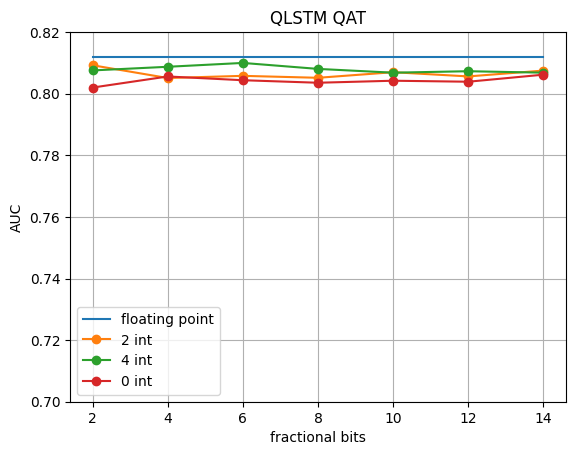

In [31]:
float_lstm = [0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379]
plt.plot([2,4,6,8,10,12, 14], float_lstm, "-", label = "floating point")
plt.plot([2,4,6,8,10,12, 14], AUC_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12, 14], AUC_4int, "-o", label = '4 int')
plt.plot([2,4,6,8,10,12, 14], AUC_0int, "-o", label = '0 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM QAT")
plt.grid()
plt.ylim([0.7, 0.82]) 

(0.6, 1.05)

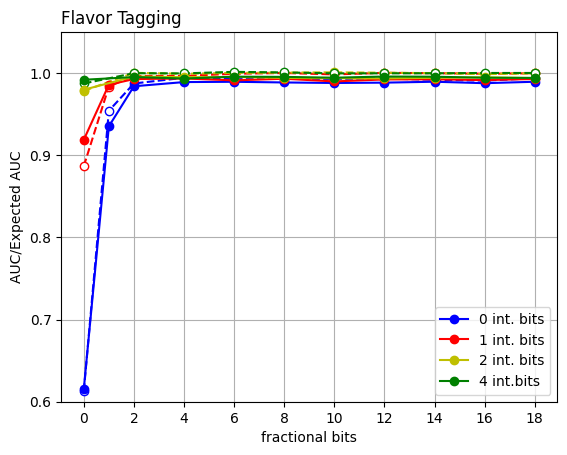

In [33]:
GRU_float = 0.8154915881472825
LSTM_float = 0.8118647593083379
        

GRU_0int = np.array(new_GRU_0int)/GRU_float
GRU_1int = np.array(new_GRU_1int)/GRU_float
GRU_2int = np.array(new_GRU_2int)/GRU_float

GRU_4int = np.array(new_GRU_4int)/GRU_float


LSTM_0int = np.array(new_LSTM_0int)/LSTM_float
LSTM_1int = np.array(new_LSTM_1int)/LSTM_float
# print(new_LSTM_0int)
LSTM_2int = np.array(new_LSTM_2int)/LSTM_float

LSTM_4int = np.array(new_LSTM_4int)/LSTM_float

x = [0,2,4,6,8,10,12,14,16,18]
default_x_ticks = range(len(x))
plt.xticks(x, x)
plt.plot([0,1,2,4,6,8,10,12,14,16,18], GRU_0int, "bo--", markerfacecolor = 'white')
plt.plot([0,1,2,4,6,8,10,12,14,16,18], GRU_1int, "ro--", markerfacecolor = 'white')
plt.plot(x, GRU_2int, "yo--", markerfacecolor = 'white')
plt.plot(x, GRU_4int, "go--", markerfacecolor = 'white')
plt.plot([0,1,2,4,6,8,10,12,14,16,18], LSTM_0int, "bo-", label = '0 int. bits')
plt.plot([0,1,2,4,6,8,10,12,14,16,18], LSTM_1int, "ro-", label = '1 int. bits')
plt.plot(x, LSTM_2int, "yo-", label = '2 int. bits')
plt.plot(x, LSTM_4int, "go-", label = '4 int.bits')
plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC/Expected AUC")
plt.title("Flavor Tagging", loc='left')
plt.grid()
plt.ylim([0.6, 1.05]) 

In [34]:
qmodel = load_model('0int_qlstm_test3_notweight/2frac_qlstm_weights.h5', custom_objects={'QLSTM': QLSTM, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qmodel, f"qat2int2fra_weight")

... quantizing model


{'lstm1': {'weights': [array([[-0.5 ,  0.  ,  0.5 , ...,  0.75,  0.25,  0.25],
          [-0.25, -0.25, -0.25, ..., -0.25,  0.25, -0.75],
          [ 0.  ,  0.  ,  0.75, ..., -0.25,  0.  ,  0.  ],
          [-0.5 ,  0.25,  0.75, ...,  0.25,  0.25,  0.25],
          [ 0.  , -0.5 ,  0.25, ...,  0.  , -0.75,  0.25],
          [ 0.25, -0.5 ,  0.  , ..., -0.25, -0.5 , -0.25]], dtype=float32),
   array([[-0.25 ,  0.125,  0.   , ...,  0.25 ,  0.   ,  0.   ],
          [-0.25 , -0.125,  0.   , ...,  0.   , -0.125, -0.125],
          [ 0.5  ,  0.125,  0.25 , ...,  0.25 ,  0.   ,  0.25 ],
          ...,
          [ 0.   ,  0.125,  0.   , ...,  0.   ,  0.   ,  0.   ],
          [ 0.   , -0.125,  0.   , ...,  0.25 ,  0.   ,  0.   ],
          [ 0.   , -0.125,  0.   , ...,  0.25 ,  0.   , -0.25 ]],
         dtype=float32),
   array([ 0.25,  0.  ,  0.5 , -0.25,  0.5 ,  0.  ,  0.25,  0.5 ,  0.  ,
           0.5 ,  0.  ,  0.  ,  0.25,  0.5 ,  0.25,  0.5 ,  0.  ,  0.  ,
           0.  ,  0.25,  0.25,  

## Post Training Quantization

## QLSTM

In [9]:
lstm = load_model('lstm_test2/model_lstm_weights.h5')

OSError: No file or directory found at new_lstm/model_lstm_weights.h5

In [8]:
# PTQ2int = []
# PTQ4int = []
PTQ1int = []
PTQ0int = []
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights
for i in [0, 1]:
    for j in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
        qmodel = model_quantize(lstm, config, total_bits, transfer_weights=True)

#         qmodel.summary()

        for layer in qmodel.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
            else:
                print(layer.name)
                
        model_save_quantized_weights(qmodel, f"ptq{i}int{j}fra_weight")
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
        if i == 0:
            PTQ0int.append(auc_score)
        else:
            PTQ1int.append(auc_score)

NameError: name 'lstm' is not defined

In [18]:
PTQ_2int = [0.7138402385262174, 0.7697426759545337, 0.795030969988355, 0.7959740415614672, 0.7965695165044027, 0.7965597107777665, 0.796992236571457]

In [19]:
PTQ_4int = [0.7204539145373472, 0.7788773707089733, 0.7948387248147831, 0.7965026440227403, 0.7993372082142057, 0.7999884160098358, 0.8001326665853764]

In [24]:
print(PTQ2int)

[0.7697456491241724, 0.7950334429664642, 0.7962076821540339, 0.7965694400474576, 0.7965596510581459, 0.7969792420735934, 0.7971674337337867]


In [25]:
print(PTQ4int)

[0.778671831721396, 0.7946760751838718, 0.7966748955925538, 0.7977211569496075, 0.7976043675022462, 0.7993241590003554, 0.7999746037087557]


(0.7, 0.82)

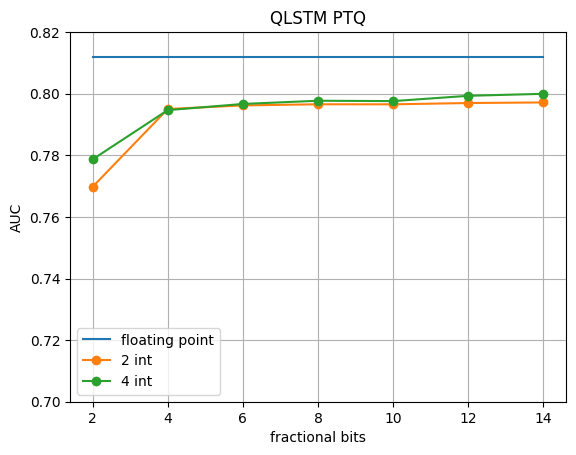

In [26]:
float_lstm = [0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379]
plt.plot([2,4,6,8,10,12,14], float_lstm, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], PTQ2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], PTQ4int, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM PTQ")
plt.grid()
plt.ylim([0.7, 0.82]) 

## QGRU

In [40]:
gru = load_model('gru_test3/gru_weights.h5')

In [41]:
PTQ2intgru = []
PTQ4intgru = []
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
        qmodel = model_quantize(gru, config, total_bits, transfer_weights=True)

#         qmodel.summary()

        for layer in qmodel.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
            else:
                print(layer.name)
                
#         model_save_quantized_weights(qmodel, f"ptq{i}int{j}fra_weight")
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
        if i == 2:
            PTQ2intgru.append(auc_score)
        else:
            PTQ4intgru.append(auc_score)

input_1
gru kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1) recurrent: quantized_bits(5,2,1,alpha='auto_po2') state: quantized_bits(5,2,1)
dense_0 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
relu_0
dense_1 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
relu_1
dense_2 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
output_softmax
294/294 [==============================] - 15s 47ms/step
AUC score: 0.756710119543415
input_1
gru kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1) recurrent: quantized_bits(7,2,1,alpha='auto_po2') state: quantized_bits(7,2,1)
dense_0 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
relu_0
dense_1 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
relu_1
dense_2 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
output_softmax
294/294 [=================

(0.7, 0.82)

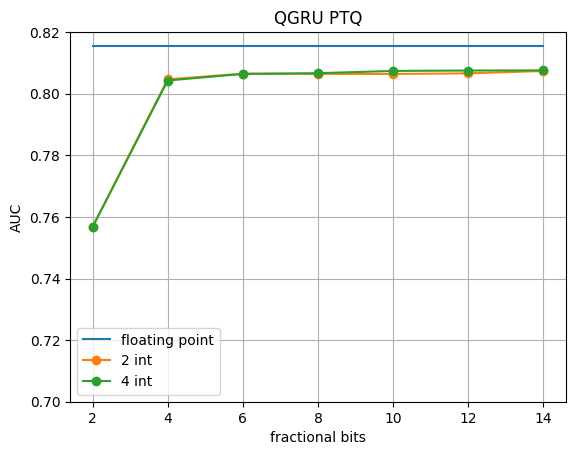

In [42]:
GRU_float = [0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825]
plt.plot([2,4,6,8,10,12,14], GRU_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], PTQ2intgru, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], PTQ4intgru, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU PTQ")
plt.grid()
plt.ylim([0.7, 0.82])

## Check AUC detail 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    cbar = plt.colorbar()
    plt.clim(0,1)
    cbar.set_label(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plotRoc(y, predict_test, linestyle, legend=True):
    
    labels = ['b vs l (pb/pl)', 'b vs c (pb/pc)']
    
    pb_b = predict_test[:,0] [y[:,0] == 1]
    pc_b = predict_test[:,1] [y[:,0] == 1]
    pl_b = predict_test[:,2] [y[:,0] == 1]
    
    pc_c = predict_test[:,1] [y[:,1] == 1]
    pb_c = predict_test[:,0] [y[:,1] == 1]
    
    pl_l = predict_test[:,2] [y[:,2] == 1]
    pb_l = predict_test[:,0] [y[:,2] == 1]
    
    hist_b_bvl = np.histogram( pb_b/(pb_b+pl_b), range=(0,1), bins=100000 )
    hist_l_bvl = np.histogram( pb_l/(pb_l+pl_l), range=(0,1), bins=100000 )

    hist_b_bvc = np.histogram( pb_b/(pb_b+pc_b), range=(0,1), bins=100000 )
    hist_c_bvc = np.histogram( pb_c/(pb_c+pc_c), range=(0,1), bins=100000 )

    hist_b_bvl_eff = hist_b_bvl[0][::-1].cumsum()[::-1]/hist_b_bvl[0].sum()
    hist_l_bvl_eff = hist_l_bvl[0][::-1].cumsum()[::-1]/hist_l_bvl[0].sum()
    
    hist_b_bvc_eff = hist_b_bvc[0][::-1].cumsum()[::-1]/hist_b_bvc[0].sum()
    hist_c_bvc_eff = hist_c_bvc[0][::-1].cumsum()[::-1]/hist_c_bvc[0].sum()
    
    auc_bvl = auc(hist_l_bvl_eff, hist_b_bvl_eff)
    auc_bvc = auc(hist_c_bvc_eff, hist_b_bvc_eff)
    
    plt.plot( hist_b_bvl_eff, hist_l_bvl_eff, label=f'b vs l (pb/pl), AUC = {auc_bvl:.2f}', linestyle=linestyle )
    plt.plot( hist_b_bvc_eff, hist_c_bvc_eff, label=f'b vs c (pb/pc), AUC = {auc_bvc:.2f}', linestyle=linestyle )
    
    plt.semilogy()
    plt.xlabel("b-Jet Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    if legend: plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

def rocData(y, predict_test):
    
    labels = ['b vs l (pb/pl)', 'b vs c (pb/pc)']
    
    pb_b = predict_test[:,0] [y[:,0] == 1]
    pc_b = predict_test[:,1] [y[:,0] == 1]
    pl_b = predict_test[:,2] [y[:,0] == 1]
    
    pc_c = predict_test[:,1] [y[:,1] == 1]
    pb_c = predict_test[:,0] [y[:,1] == 1]
    
    pl_l = predict_test[:,2] [y[:,2] == 1]
    pb_l = predict_test[:,0] [y[:,2] == 1]
    
    
    hist_b_bvl = np.histogram( pb_b/(pb_b+pl_b), range=(0,1), bins=1000 )
    hist_l_bvl = np.histogram( pb_l/(pb_l+pl_l), range=(0,1), bins=1000 )

    hist_b_cvl = np.histogram( pb_b/(pb_b+pc_b), range=(0,1), bins=1000 )
    hist_c_cvl = np.histogram( pb_c/(pb_c+pc_c), range=(0,1), bins=1000 )

    hist_b_bvl_eff = hist_b_bvl.cumsum()/hist_b_bvl.sum()
    hist_l_bvl_eff = hist_l_bvl.cumsum()/hist_l_bvl.sum()
    
    hist_b_cvl_eff = hist_b_cvl.cumsum()/hist_b_cvl.sum()
    hist_c_cvl_eff = hist_c_cvl.cumsum()/hist_c_cvl.sum()

    df = pd.DataFrame()

    fpr = {}
    tpr = {}
    auc1 = {}

    for i, label in enumerate(labels):
        df[label] = y[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
    return effs, auc1

def makeRoc(y, predict_test, linestyle='-', legend=True):
      
    plotRoc(y, predict_test, linestyle, legend)
    
#     effs, auc1 = rocData(y, predict_test, labels)
#     plotRoc(fpr, tpr, auc1, labels, linestyle, legend=legend)
#     return predict_test

def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

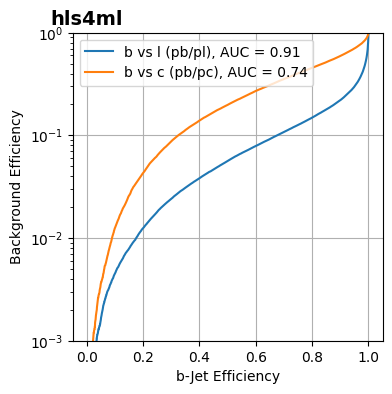

In [39]:
plt.figure(figsize=(4,4))
_ = makeRoc(y_test, y_keras)